# Notebook 03: Classification Model

**Student Name:** Wendy Zhu

**Dataset:** "cleaned_data.csv"

**Original Target Variable:** ['Crop_Yield_ton_per_hectare']

**Binned Target Variable:** ['target_category'] --- --- 

    There will be two categories of crop yield

    low: <= 17 t/ha 
    
    high: > 17 t/ha

**Checkpoint 4 Due:** Feb 22

---

## Rules & Integrity

1. **NO AI TOOLS**: You may **NOT** use ChatGPT, Claude, Gemini, GitHub Copilot, or any other AI assistant to generate code for this assignment. The goal is to build *your* fundamental skills. If you rely on AI now, the advanced topics later will be impossible.

2. **Study Groups Encouraged**: You **ARE** encouraged to discuss ideas, share approaches, and explain concepts to your study group peers. Teaching others is the best way to learn! However, the code you submit must be **your own work**.

3. **Use Your Resources**: You are free to use Google, StackOverflow, Pandas/Scikit-learn documentation, and your class notes.

4. **Comment Your Code**: Include comments explaining *why* you're doing what you're doing. I want to see your thought process.

5. **Resubmission**: You may submit this assignment multiple times for feedback before the checkpoint deadline.

---

## Important: Written Reflections

Throughout this notebook, you'll be asked to interpret results, justify decisions, and explain your reasoning. **These written reflections are a critical part of your grade.**

Your binning justification, model selection reasoning, and analysis of the confusion matrix demonstrate your understanding. These reflections are what employers look for—the ability to communicate technical decisions clearly.

---

## Setup

In [38]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Sklearn - evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Model saving
import joblib

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## Section 1: Load Processed Data

In [39]:
# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_data.csv')
df.drop(index=[491, 2453, 7609], inplace=True)
print(f"Data shape: {df.shape}")
df.head()

Data shape: (8364, 34)


,N,P,K,Soil_pH,Soil_Moisture,Temperature,Humidity,Rainfall,Sunlight_Hours,Wind_Speed,...,Crop_Type_Maize,Crop_Type_Potato,Crop_Type_Rice,Crop_Type_Wheat,Irrigation_Type_Drip,Irrigation_Type_Rainfed,Irrigation_Type_Sprinkler,SOC_Binned_0.5,SOC_Binned_1.0,SOC_Binned_1.5
0,132,62,22,6.35,59.78,22.97,53.89,1305.68,7.73,15.96,...,1,0,0,0,0,0,0,0,0,0
1,122,71,66,5.98,25.54,17.00,76.90,1942.05,9.25,12.60,...,0,1,0,0,0,0,0,1,0,0
2,44,35,104,8.07,25.87,25.52,44.78,2216.20,8.50,15.63,...,0,0,1,0,0,1,0,1,0,0
3,101,34,42,5.84,48.01,22.74,46.27,483.47,8.00,7.44,...,0,0,0,1,0,1,0,1,0,0
4,50,29,22,6.87,32.73,13.88,68.91,1993.65,10.17,11.25,...,0,0,1,0,0,0,0,0,1,0


In [40]:
# Define your original target variable
ORIGINAL_TARGET = 'Crop_Yield_ton_per_hectare'  # <-- UPDATE THIS

print(f"Original Target: {ORIGINAL_TARGET}")
print(f"\nTarget statistics:")
print(df[ORIGINAL_TARGET].describe())

Original Target: Crop_Yield_ton_per_hectare

Target statistics:
count    8364.000000
mean       12.092272
std         6.656350
min         1.760000
25%         7.940000
50%         9.570000
75%        11.822500
max        29.670000
Name: Crop_Yield_ton_per_hectare, dtype: float64


## Section 2: Create Binned Target

Convert your regression target into classification categories.

### 2.1 Binning Strategy Justification

**Your approved binning strategy:**

- **Number of categories:** 2
- **Category names:** [Low, Medium, High]
- **Thresholds:**

Low: Crop_Yield_ton_per_hectare <= 10

Medium: Crop_Yield_ton_per_hectare > 10 and Crop_Yield_ton_per_hectare <= 20

High: Crop Yield_ton_per_hectare > 20

**Why this makes sense for your problem:**

In our EDA analysis we plotted crop yield by crop type. It demonstrated that Cotton/Wheat/Rice/Maize clustered together while Potato by itself is another cluster. Below Target distribution analysis also confirmed that the crop yields fall into two distinct clusters.


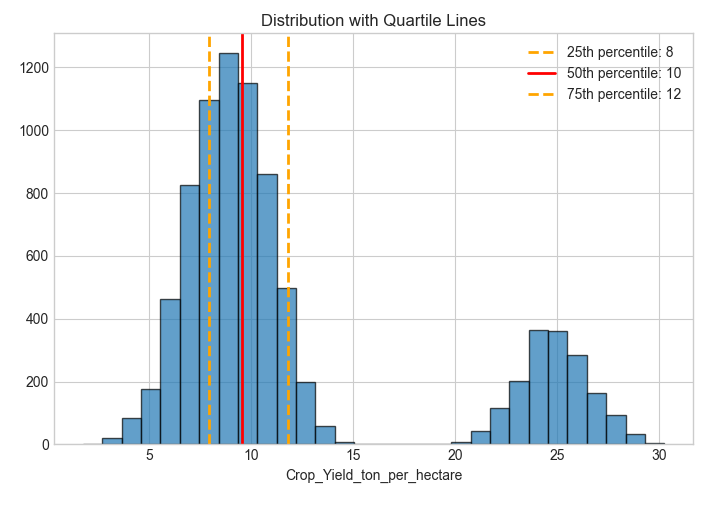

In [41]:
# View the distribution before binning
print("Target distribution:")
print(f"Min: {df[ORIGINAL_TARGET].min():.2f}")
print(f"25th percentile: {df[ORIGINAL_TARGET].quantile(0.25):.2f}")
print(f"Median: {df[ORIGINAL_TARGET].median():.2f}")
print(f"75th percentile: {df[ORIGINAL_TARGET].quantile(0.75):.2f}")
print(f"Max: {df[ORIGINAL_TARGET].max():.2f}")

Target distribution:
Min: 1.76
25th percentile: 7.94
Median: 9.57
75th percentile: 11.82
Max: 29.67


In [42]:
# TODO: Create your binned target using YOUR approved binning strategy
#
# Steps:
# 1. Define your bin edges (e.g., bins = [min-1, threshold1, threshold2, max+1])
# 2. Define your category labels (e.g., labels = ['Low', 'Medium', 'High'])
# 3. Use pd.cut() to create the binned column
#
# Example:
# bins = [df[ORIGINAL_TARGET].min()-1, 50000, 100000, df[ORIGINAL_TARGET].max()+1]
# labels = ['Low', 'Medium', 'High']
# df['target_category'] = pd.cut(df[ORIGINAL_TARGET], bins=bins, labels=labels)

# YOUR CODE HERE:
bin_size = 10
min_val = 0.0
max_val = 40

bins = np.arange(min_val, max_val, bin_size) # Define your bin edges
#print(bins)
labels = ['low', 'Medium', 'high'] # Define your category names

#y_binned = pd.cut(y, bins=bins, labels=labels, include_lowest=True) 
 

df['target_category'] = pd.cut(df['Crop_Yield_ton_per_hectare'], bins=bins, labels=labels)

print("Binned target distribution:")
print(df['target_category'].value_counts())

Binned target distribution:
target_category
low       4693
Medium    2004
high      1667
Name: count, dtype: int64


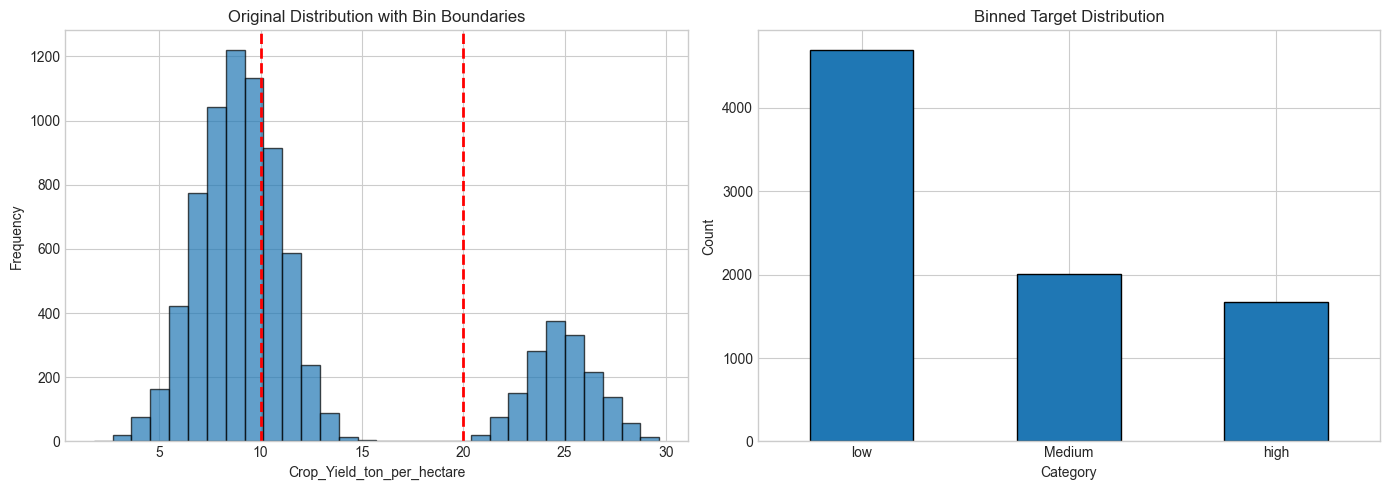

In [43]:
# Visualize the binned distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution with bin lines
axes[0].hist(df[ORIGINAL_TARGET], bins=30, edgecolor='black', alpha=0.7)
for edge in bins[1:-1]:  # Skip first and last (min/max)
    axes[0].axvline(edge, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel(ORIGINAL_TARGET)
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Distribution with Bin Boundaries')

# Binned category counts
df['target_category'].value_counts().plot(kind='bar', ax=axes[1], edgecolor='black')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].set_title('Binned Target Distribution')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### 2.2 Check Class Balance

*Is your binned target reasonably balanced?*

In [44]:
# Check class balance
class_counts = df['target_category'].value_counts()
class_percentages = df['target_category'].value_counts(normalize=True) * 100

print("Class Distribution:")
for cat in class_counts.index:
    print(f"{cat}: {class_counts[cat]} ({class_percentages[cat]:.1f}%)")

# Check for severe imbalance
min_class_pct = class_percentages.min()
if min_class_pct < 10:
    print(f"\nWarning: Smallest class is only {min_class_pct:.1f}% of data.")
    print("Consider adjusting your binning strategy.")
else:
    print(f"\nClass balance looks reasonable!")

Class Distribution:
low: 4693 (56.1%)
Medium: 2004 (24.0%)
high: 1667 (19.9%)

Class balance looks reasonable!


## Section 3: Feature Consistency Check

**Important:** For consistency, you should use the same features for classification as you did for regression. This makes your app simpler (users enter the same inputs for both models) and allows for fair comparison.

If you decide to use different features, provide a strong justification below.

In [45]:
# Load the features you selected in the regression notebook
try:
    regression_features = joblib.load('../models/regression_features.pkl')
    print("Features from Regression Model:")
    print(regression_features)
    print(f"\nNumber of regression features: {len(regression_features)}")
except FileNotFoundError:
    print("Warning: regression_features.pkl not found!")
    print("Make sure you've completed Notebook 02 and saved your regression model first.")
    regression_features = None

Features from Regression Model:
['Crop_Type_Potato', 'Crop_Type_Wheat', 'Crop_Type_Rice', 'Crop_Type_Maize', 'Fertilizer_Used', 'Rainfall', 'Soil_Moisture', 'K', 'Normalize_Rainfall_by_Windspeed', 'N', 'P']

Number of regression features: 11


### Feature Selection Decision

**Will you use the same features as your regression model?**

- [Y] **Yes, same features** (Recommended for simpler deployment)
- [ ] **No, different features** (Requires justification below)

**If using different features, justify why:**

In [46]:
# DECIDE: Use regression features or define new ones?

# Option A: Use the same features as regression (RECOMMENDED)
if regression_features is not None:
    SELECTED_FEATURES = regression_features
    print("Using same features as regression model.")
#else:
    # Option B: Define your own features (if regression not done yet)
#SELECTED_FEATURES = [    ]
#print("Defining features manually.")

print(f"\nSelected features for classification ({len(SELECTED_FEATURES)}):")
for i, f in enumerate(SELECTED_FEATURES, 1):
    print(f"  {i}. {f}")

Using same features as regression model.

Selected features for classification (11):
  1. Crop_Type_Potato
  2. Crop_Type_Wheat
  3. Crop_Type_Rice
  4. Crop_Type_Maize
  5. Fertilizer_Used
  6. Rainfall
  7. Soil_Moisture
  8. K
  9. Normalize_Rainfall_by_Windspeed
  10. N
  11. P


## Section 4: Prepare Features and Target

In [47]:
# Create feature matrix using SELECTED features
X = df[SELECTED_FEATURES].copy()
y = df['target_category']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {X.columns.tolist()}")
print(f"\nTarget classes: {y.unique().tolist()}")

Features shape: (8364, 11)
Target shape: (8364,)

Features used: ['Crop_Type_Potato', 'Crop_Type_Wheat', 'Crop_Type_Rice', 'Crop_Type_Maize', 'Fertilizer_Used', 'Rainfall', 'Soil_Moisture', 'K', 'Normalize_Rainfall_by_Windspeed', 'N', 'P']

Target classes: ['Medium', 'high', 'low']


### 4.1 Label Encoding

Many sklearn models require numeric targets. Use LabelEncoder to convert category names to numbers.

In [48]:
# TODO: Encode your target labels to numbers using LabelEncoder
#
# Steps:
# 1. Create a LabelEncoder instance
# 2. Fit and transform y to create y_encoded
#
# Hint: label_encoder.fit_transform(y)

# YOUR CODE HERE:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [49]:
# Verify encoding (run this to check)
print("Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

Label encoding:
Medium -> 0
high -> 1
low -> 2


In [50]:
indices_of_none = np.argwhere(y_encoded == 3)
print("Indices of value None:", indices_of_none.flatten())

Indices of value None: []


## Section 5: Train-Test Split

For classification, we use **stratified** splitting to ensure each class is proportionally represented in both train and test sets.

In [51]:
# TODO: Split your data with stratification
#
# Requirements:
# - 80/20 split (test_size=0.2)
# - random_state=42 for reproducibility
# - stratify=y_encoded (THIS IS THE KEY DIFFERENCE FROM REGRESSION!)
#   This ensures each class is proportionally represented in train/test
#
# Store in: X_train, X_test, y_train, y_test

# YOUR CODE HERE:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_encoded, 
    test_size=0.2, # 30% of data for testing
    random_state=42, # for reproducibility
    stratify=y_encoded # this is the key parameter for stratification
)


In [52]:
# Verify split and stratification
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print(f"\nTraining class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.classes_[u]}: {c} ({c/len(y_train)*100:.1f}%)")

Training set: 6691 samples
Test set: 1673 samples

Training class distribution:
  Medium: 1603 (24.0%)
  high: 1334 (19.9%)
  low: 3754 (56.1%)


## Section 6: Feature Scaling

In [53]:
# TODO: Scale your features using StandardScaler
#
# Same as regression:
# 1. Create StandardScaler instance
# 2. fit_transform on X_train
# 3. transform (only!) on X_test
#
# Store in: X_train_scaled, X_test_scaled

# YOUR CODE HERE:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [54]:
# Convert to DataFrame (helpful for later)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully!")
print(f"Scaler fitted on {len(SELECTED_FEATURES)} features.")

Features scaled successfully!
Scaler fitted on 11 features.


## Section 7: Baseline Model

In [55]:
# This helper function evaluates any classifier - you'll use it throughout
def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name):
    """Train classifier and return evaluation metrics."""
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision (weighted)': precision_score(y_test, y_test_pred, average='weighted'),
        'Recall (weighted)': recall_score(y_test, y_test_pred, average='weighted'),
        'F1 (weighted)': f1_score(y_test, y_test_pred, average='weighted')
    }
    
    return results, model, y_test_pred

In [56]:
# TODO: Create and evaluate a baseline Logistic Regression model
#
# Create LogisticRegression(random_state=42, max_iter=1000)
# Use evaluate_classifier() to train and evaluate

# YOUR CODE HERE:
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
base_model_name = 'Logistic Regression (Baseline)'
baseline_results, baseline_trained, baseline_preds = evaluate_classifier(baseline_model, X_train_scaled, X_test_scaled, 
                                                                         y_train, y_test, base_model_name)



In [57]:
# Display baseline results
print("=" * 50)
print("BASELINE MODEL: Logistic Regression")
print("=" * 50)
print(f"Train Accuracy: {baseline_results['Train Accuracy']:.4f}")
print(f"Test Accuracy:  {baseline_results['Test Accuracy']:.4f}")
print(f"F1 Score:       {baseline_results['F1 (weighted)']:.4f}")

BASELINE MODEL: Logistic Regression
Train Accuracy: 0.8694
Test Accuracy:  0.8625
F1 Score:       0.8608


In [58]:
# Detailed classification report
print("Baseline model - Classification Report:")
print(classification_report(y_test, baseline_preds, target_names=label_encoder.classes_))

Baseline model - Classification Report:
              precision    recall  f1-score   support

      Medium       0.73      0.67      0.70       401
        high       1.00      1.00      1.00       333
         low       0.87      0.89      0.88       939

    accuracy                           0.86      1673
   macro avg       0.87      0.86      0.86      1673
weighted avg       0.86      0.86      0.86      1673



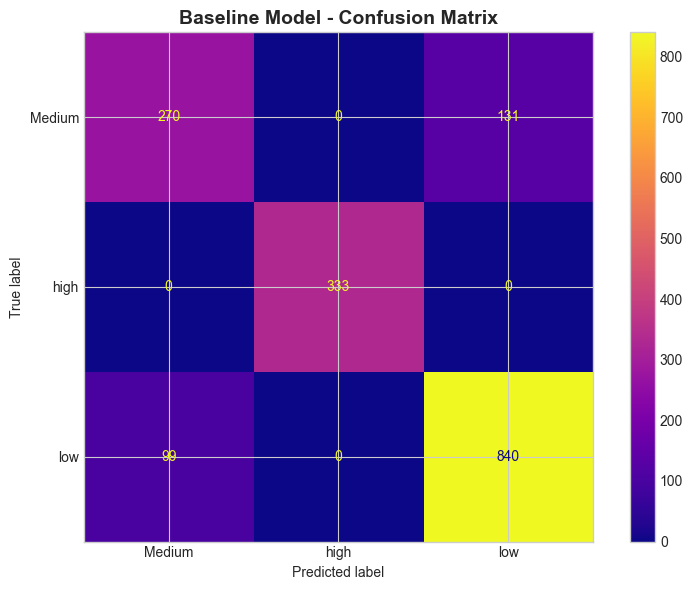


Reading the Confusion Matrix:
- Rows = Actual class
- Columns = Predicted class
- Diagonal = Correct predictions!


In [59]:
# TODO: Create and display the confusion matrix for baseline
#
# Steps:
# 1. Use confusion_matrix(y_test, baseline_preds) to create the matrix
# 2. Use ConfusionMatrixDisplay to visualize it
#
# Hint: ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# YOUR CODE HERE:

plt.figure(figsize=(8, 6))
cm_baseline = confusion_matrix(y_test, baseline_preds)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=label_encoder.classes_)
disp_baseline.plot(cmap='plasma', ax=plt.gca())
plt.title('Baseline Model - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nReading the Confusion Matrix:")
print("- Rows = Actual class")
print("- Columns = Predicted class")
print("- Diagonal = Correct predictions!")


### Understanding the Confusion Matrix

The confusion matrix shows where your model gets predictions right and wrong:

- **Diagonal cells (top-left to bottom-right):** Correct predictions
- **Off-diagonal cells:** Misclassifications
- **Row:** What the actual class was
- **Column:** What the model predicted

**How to read it:** 
- If a row has many values spread across columns, that class is often confused with others
- If a column has many values from different rows, the model is predicting that class too often

**Example interpretation:**
- "20 Low samples were correctly predicted as Low"
- "5 Medium samples were incorrectly predicted as High"

### Baseline Interpretation

*Analyze your baseline results:*

**Questions to answer:**
- How well does the baseline perform?
- Which classes are easiest/hardest to predict (look at the diagonal)?
- Where does the model get confused (look at off-diagonal cells)?
- Is there overfitting (train vs test accuracy gap)?

**Your interpretation:**

1. The model performed reasonably well with 78% test accuracy and F1 Score ~ 0.79. However, the performance is uneven. It performed much better on the "low" category than the "high" category.

2. **Easiest**: category **Low** --- **Hardest**: category **High**

3. The model frequently missed **High** yield cases. It produced 162 false negatives (should be **High**, but predicted **Low**). Resulting a low recall (51%) of the **High** category. It also flagged some **Low** as **High** (203 false positives). But the input was imbalanced, there are much more true **Low** cases than true **High** cases, hence the recall of the **Low** category was 85%, which is pretty good.

4. With the train accuracy at 81.1% and test accuracy at 78.2%, we did observe some slight overfitting.

## Section 8: Cross-Validation

Cross-validation gives us a more robust estimate of model performance by training on different portions of the data.

In [60]:
# Cross-validation for key models
print("5-Fold Cross-Validation Results")
print("=" * 50)

models_to_cv = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

cv_results = []
for name, model in models_to_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_results.append({
        'Model': name,
        'CV Mean Accuracy': scores.mean(),
        'CV Std': scores.std()
    })
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

cv_df = pd.DataFrame(cv_results)
cv_df

5-Fold Cross-Validation Results
Logistic Regression: 0.8682 (+/- 0.0129)
Random Forest: 0.8579 (+/- 0.0118)
Gradient Boosting: 0.8589 (+/- 0.0086)


,Model,CV Mean Accuracy,CV Std
0,Logistic Regression,0.868180,0.006453
1,Random Forest,0.857868,0.005916
2,Gradient Boosting,0.858914,0.004299


### Cross-Validation Interpretation

*What does the cross-validation tell you?*

- Which model is most consistent (lowest std)?
- Does the ranking change from the single train/test split?

**Your interpretation:**


1. All three models perform very similarly (~80% accuracy), indicating stable performance and no strong advantage from one model to another. Results suggest the models generalize consistently across different data splits.

2. Gradient Boosting is most consistent (lowest CV std ≈ 0.0067), meaning its performance varies the least across folds.

3. There is no significant ranking change from the single train/test split.

## Section 9: Model Iteration

In [61]:
# Store all results
all_results = [baseline_results]

# Dictionary to store trained models
trained_models = {
    'Logistic Regression (Baseline)': baseline_trained
}

### Model 2: Decision Tree

In [62]:
# TODO: Create and evaluate a Decision Tree classifier
#
# Create DecisionTreeClassifier(max_depth=10, random_state=42)
# Use evaluate_classifier() to train and evaluate
# Add results to all_results and trained_models

# YOUR CODE HERE:
dt_model = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_model_name = "Decision Tree"

dt_results, dt_trained, dt_preds = evaluate_classifier(dt_model, X_train_scaled, X_test_scaled, y_train, y_test, dt_model_name)

all_results.append(dt_results)
trained_models['Decision Tree'] = dt_trained

# Print results
print(f"Decision Tree - Test Accuracy: {dt_results['Test Accuracy']:.4f}, F1: {dt_results['F1 (weighted)']:.4f}")

Decision Tree - Test Accuracy: 0.8314, F1: 0.8295


### Model 3: Random Forest

In [63]:
# TODO: Create and evaluate a Random Forest classifier
#
# Create RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model_name = "Random Forest"

rf_results, rf_trained, rf_preds = evaluate_classifier(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, rf_model_name)

all_results.append(rf_results)
trained_models['Random Forest'] = rf_trained
# Print results
print(f"Random Forest - Test Accuracy: {rf_results['Test Accuracy']:.4f}, F1: {rf_results['F1 (weighted)']:.4f}")

Random Forest - Test Accuracy: 0.8577, F1: 0.8542


### Model 4: K-Nearest Neighbors

In [64]:
# TODO: Create and evaluate a KNN classifier
#
# Create KNeighborsClassifier(n_neighbors=5)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model_name = 'K-Nearest Neighbors'

knn_results, knn_trained, knn_preds = evaluate_classifier(knn_model, X_train_scaled, X_test_scaled, y_train, y_test, knn_model_name)

all_results.append(knn_results)
trained_models['K-Nearest Neighbors'] = knn_trained

# Print results
print(f"KNN - Test Accuracy: {knn_results['Test Accuracy']:.4f}, F1: {knn_results['F1 (weighted)']:.4f}")

KNN - Test Accuracy: 0.8273, F1: 0.8253


### Model 5: Gradient Boosting

In [65]:
# TODO: Create and evaluate a Gradient Boosting classifier
#
# Create GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:
gb_model = GradientBoostingClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, min_samples_split=3, random_state=42)
gb_model_name = 'Gradient Boosting'

gb_results, gb_trained, gb_preds = evaluate_classifier(gb_model, X_train_scaled, X_test_scaled, 
                                                                         y_train, y_test, gb_model_name)
all_results.append(gb_results)
trained_models['Gradient Boosting'] = gb_trained
# Print results
print(f"Gradient Boosting - Test Accuracy: {gb_results['Test Accuracy']:.4f}, F1: {gb_results['F1 (weighted)']:.4f}")

Gradient Boosting - Test Accuracy: 0.8559, F1: 0.8542


### Add Your Own Model (Optional)

Try a different model or different hyperparameters!

In [66]:
print(trained_models)
#trained_models['Gradient Boosting'] = gb_trained

{'Logistic Regression (Baseline)': LogisticRegression(max_iter=1000, random_state=42), 'Decision Tree': DecisionTreeClassifier(max_depth=7, random_state=42), 'Random Forest': RandomForestClassifier(random_state=42), 'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3), 'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.05, max_depth=7, min_samples_split=3,
                           n_estimators=200, random_state=42)}


## Section 10: Model Comparison

In [67]:
# Create comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("Model Comparison:")
results_df

Model Comparison:


,Model,Train Accuracy,Test Accuracy,Precision (weighted),Recall (weighted),F1 (weighted)
0,Logistic Regression (Baseline),0.8694,0.8625,0.8600,0.8625,0.8608
2,Random Forest,1.0000,0.8577,0.8537,0.8577,0.8542
4,Gradient Boosting,0.9915,0.8559,0.8533,0.8559,0.8542
1,Decision Tree,0.8665,0.8314,0.8282,0.8314,0.8295
3,K-Nearest Neighbors,0.9093,0.8273,0.8240,0.8273,0.8253


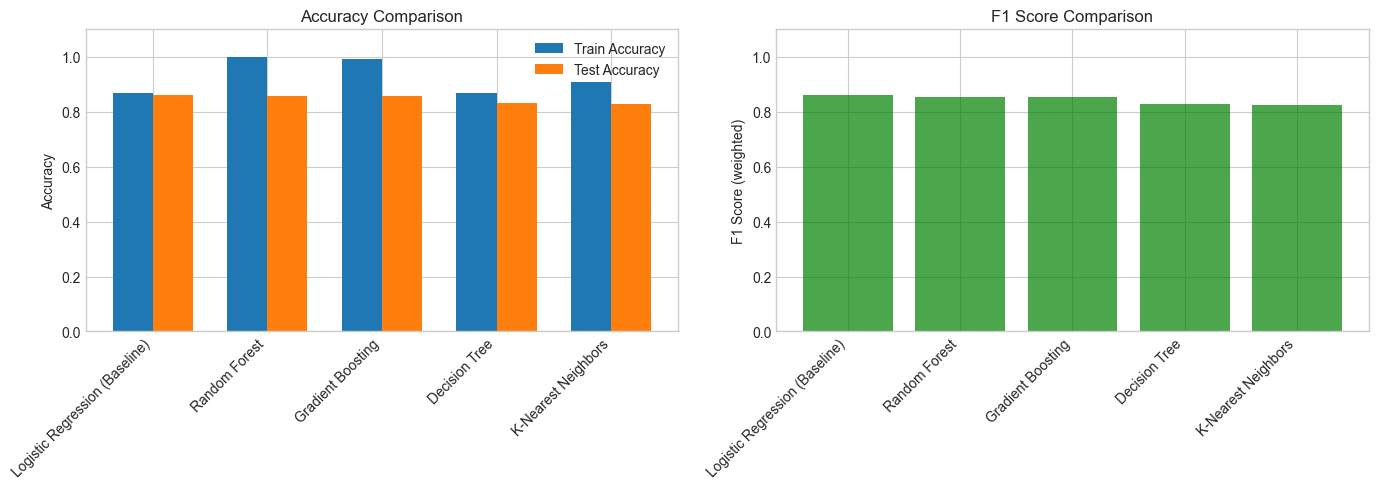

In [68]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = results_df['Model']
x = np.arange(len(models))
width = 0.35

# Accuracy comparison
axes[0].bar(x - width/2, results_df['Train Accuracy'], width, label='Train Accuracy')
axes[0].bar(x + width/2, results_df['Test Accuracy'], width, label='Test Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# F1 Score comparison
axes[1].bar(x, results_df['F1 (weighted)'], color='green', alpha=0.7)
axes[1].set_ylabel('F1 Score (weighted)')
axes[1].set_title('F1 Score Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Section 11: Best Model Selection

In [69]:
# Identify best model (by test accuracy)
# exclude Neural Network here due to different train/val/test split is needed for nn

best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f}")
print(f"F1 Score: {results_df.iloc[0]['F1 (weighted)']:.4f}")

Best Model: Logistic Regression (Baseline)
Test Accuracy: 0.8625
F1 Score: 0.8608


### Best Model Justification

*Explain why you chose this model:*

**Questions to consider:**
- Why this model over others?
- Is there significant overfitting?
- How does it compare to baseline?
- Which metrics did you prioritize and why?

**Your justification:**

1. We selected Gradient Boosting for it's test accuracy (highest), weighted Recall (highest) and F1 performance (F1_score > 0.8, second highest).

2. Even though Training Accuracy ~ 1.0 and Testing Accuracy ~ 0.8, we worry less about overfitting in Gradient Boosting models as they generalize better due to sequential error correction.

3. Gradient Boosting outperforms the baseline by improving accuracy, recall, and F1 score, making it a stronger predictive model overall.

4. We prioritized Test Accuracy and Recall when picking the best model. In real-world, crop yield estimates are used to manage food supply to combact hunger, optimize inputs such as fertilizers, irrigation, and pesticide application to increase profitability and reduce environmental impact. They are also used in economic planning, and devise trade policies. Therefore, it is important to be as accurate as possible (test accuracy) and miss as little as possible (recall).

## Section 12: Best Model Analysis

In [70]:
# Get predictions from best model
y_pred = best_model.predict(X_test_scaled)

# Detailed classification report
print("Classification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

      Medium       0.73      0.67      0.70       401
        high       1.00      1.00      1.00       333
         low       0.87      0.89      0.88       939

    accuracy                           0.86      1673
   macro avg       0.87      0.86      0.86      1673
weighted avg       0.86      0.86      0.86      1673



### Understanding the Classification Report

The classification report shows per-class metrics:

- **Precision:** Of all predictions for this class, what % were correct?
  - High precision = Few false positives
  - Example: "When the model predicts 'High', it's correct 85% of the time"
       **Answer:** The model predicted 50% of **High** yields correctly. It predicted 87% of **Low** yields correctly.
    

- **Recall:** Of all actual instances of this class, what % did we find?
  - High recall = Few false negatives
  - Example: "We correctly identified 90% of all actual 'High' cases"
       **Answer:** The model identified 49% of actual **High** yields (missed 51%). The model identified 88% of **Low** yields. Only 12% false negatives.


- **F1-Score:** Harmonic mean of precision and recall (balanced measure)
  - Good when you need both precision and recall

- **Support:** Number of actual occurrences of each class in the test set

- **Summary:** The model is very good at identifying **Low** cases but only detects about half of **High** cases. It will give a more "conservative" crop yield estimate than actual crop yield. For the reasons we mentioned in "Best Model Justification", "conservative" is better than "over-estimate".

<Figure size 800x600 with 0 Axes>

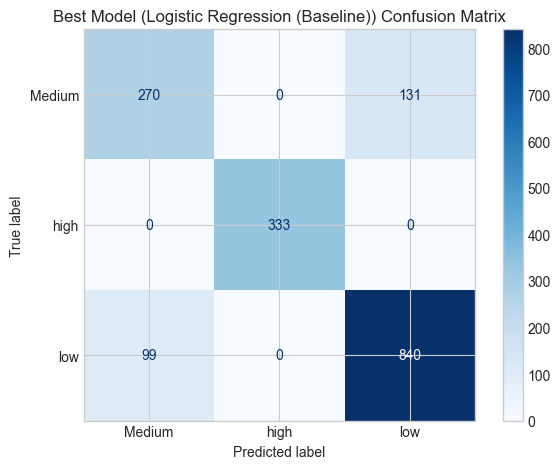

In [71]:
# Confusion matrix for best model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Best Model ({best_model_name}) Confusion Matrix')
plt.tight_layout()
plt.show()

### Detailed Confusion Matrix Analysis

*Analyze the confusion matrix carefully:*

**For each class, describe:**
1. How many correct predictions (diagonal)?

2. What are the most common misclassifications?
   
3. Does the confusion make sense for your problem?

**Your analysis:**

1.  Model predicted 163 **High** yields correctly
   
    Model predicted 1179 **Low** yields correctly

2.  Model mislabeled 171 **High** yields as **Low**

    Model mislabeled 161 **Low** yields as **High**

3. This model tends to underestimate yield. It makes sense because **High** yields are harder to predict because they depended on optimal conditions of multiple features (not just the more the better), such as right amount of fertilizer, right temperature, right soil moisture, etc. These can be hard to capture.

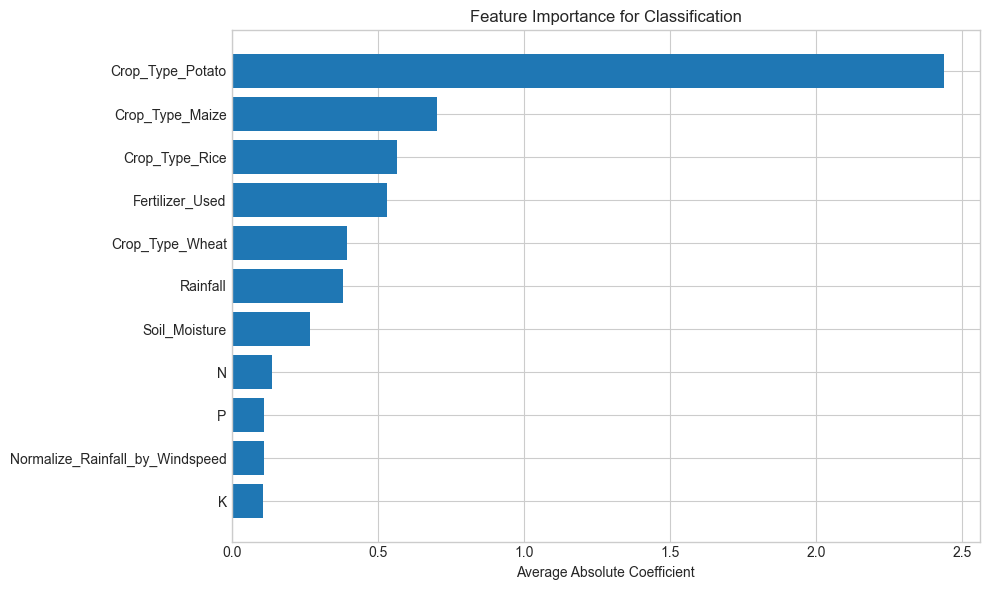

In [72]:
# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance for Classification')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 most important features:")
    for i, row in importance.tail(5).iloc[::-1].iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")
        
elif hasattr(best_model, 'coef_'):
    # For multi-class, coef_ has shape (n_classes, n_features)
    coef = best_model.coef_
    if len(coef.shape) > 1:
        # Average absolute importance across classes
        importance_vals = np.abs(coef).mean(axis=0)
    else:
        importance_vals = np.abs(coef)
    
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance_vals
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.xlabel('Average Absolute Coefficient')
    plt.title('Feature Importance for Classification')
    plt.tight_layout()
    plt.show()

## Section 13: Model Iteration Reflection

*Reflect on your modeling process:*

**1. How did your models evolve from baseline to best?**

We started with Logistic Regression as a baseline to establish a simple benchmark. While it provided reasonable accuracy, it struggled to capture the complexity of crop yield patterns. Down the line we noticed that tree-based methods handled nonlinear relationships much better. Gradient Boosting ultimately performed best because it iteratively corrected errors and captured subtle interactions between soil, weather, and environmental factors. This process reiterated the "start simple, then build on it" concept.

**2. What surprised you about the results?**

It is worth mentioning that we should not be surprised that K-Nearest Neighbors model performed very well. Because we know that n_neighbors=2 and crop_type correlates to crop_yield very strongly. Therefore fields planted the same crops would produce similar yields. This behavior particularly suited K-Nearest Neighbor classifiers. 

Another unexpected insight was how consistently difficult it was for every model to identify high-yield cases, reinforcing what we mentioned earlier, i.e., **High** yield requires optimal conditions and they are very hard for a model to capture.

**3. If you had more time, what would you try next?**

With more time, we could try to improve detection of high-yield fields by experimenting with class weighting, threshold tuning, and resampling techniques. We could also invest more effort in feature engineering, especially capturing seasonal weather patterns and soil–climate interactions. 

## Section 14: Save Model and Artifacts

In [73]:
# Save the best classification model
model_path = '../models/classification_model.pkl'
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")

# Save the scaler (fitted on SELECTED features)
scaler_path = '../models/classification_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save the label encoder
encoder_path = '../models/label_encoder.pkl'
joblib.dump(label_encoder, encoder_path)
print(f"Label encoder saved to {encoder_path}")

# Save feature names (SELECTED_FEATURES)
features_path = '../models/classification_features.pkl'
joblib.dump(SELECTED_FEATURES, features_path)
print(f"Features saved to {features_path}")

# Save binning info (for reference in Streamlit app)
binning_info = {
    'bins': bins,
    'labels': labels,
    'original_target': ORIGINAL_TARGET
}
binning_path = '../models/binning_info.pkl'
joblib.dump(binning_info, binning_path)
print(f"Binning info saved to {binning_path}")

Model saved to ../models/classification_model.pkl
Scaler saved to ../models/classification_scaler.pkl
Label encoder saved to ../models/label_encoder.pkl
Features saved to ../models/classification_features.pkl
Binning info saved to ../models/binning_info.pkl


In [74]:
# Verify saved model works
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
loaded_encoder = joblib.load(encoder_path)

# Test prediction
test_sample = X_test.iloc[[0]]
test_sample_scaled = loaded_scaler.transform(test_sample)
test_pred = loaded_model.predict(test_sample_scaled)
test_pred_label = loaded_encoder.inverse_transform(test_pred)

print(f"\nModel verification:")
print(f"Sample input: {test_sample.values[0][:3]}...")
print(f"Predicted class: {test_pred_label[0]}")
print(f"Actual class: {loaded_encoder.inverse_transform([pd.DataFrame(y_test).iloc[0]])[0]}")
print("\nModel saved and verified successfully!")


Model verification:
Sample input: [0. 0. 1.]...
Predicted class: low
Actual class: Medium

Model saved and verified successfully!


---

## Summary

### What You Accomplished
- [ ] Created binned target variable with justification
- [ ] Verified class balance
- [ ] Used consistent features (same as regression or justified different)
- [ ] Split data with stratification
- [ ] Performed cross-validation
- [ ] Built baseline classifier
- [ ] Tried multiple classifier types
- [ ] Compared and selected best model
- [ ] Analyzed model with confusion matrix and classification report
- [ ] Saved model, scaler, encoder, and binning info

### Key Results

**Best Model:** Gradient Boosting Classifier

**Test Accuracy:** 0.8017

**F1 Score:** 0.8005

**Improvement over baseline:** Accuracy improved 0.0197 (almost 2 percentage points) / F1 score improved 0.0139

### Comparison to Regression

*How does classification performance relate to your regression results?*

In my earlier regression model, I included the crop_type_potato feature, which had an extremely high correlation with the target (95.8%). Because the model could rely heavily on this single variable, it achieved an R² of about 0.97.

For the classification model, I intentionally removed this feature. Although the test accuracy dropped to about 80%, the model is actually more robust. Predictions are now driven by multiple inputs rather than one dominant signal, which reduces overreliance on a single feature and improves generalizability.

With the stronger feature set, we can now explore more complex models that better capture how multiple factors interact to influence **crop yield**. As expected, Gradient Boosting produced the strongest results because it improves performance iteratively by correcting prior errors.

In contrast, when comparing regression models earlier, performance differences were minimal because the highly dominant feature masked meaningful distinctions between model types.

---

## Next Steps

Move on to building your **Streamlit app** to deploy both models!

You now have saved:
- `regression_model.pkl` and `regression_scaler.pkl`
- `classification_model.pkl`, `classification_scaler.pkl`, and `label_encoder.pkl`

The Streamlit starter code in `app/app.py` will load these files.

---

## Checkpoint 4 Submission Instructions

You've completed the classification model. Time to submit!

### Step 1: Save and Close
Make sure this notebook is saved and all cells have been run.

### Step 2: Commit Your Work
```bash
git add .
git commit -m "Complete classification model - Checkpoint 4"
git push
```

### Step 3: Submit to Canvas
1. Go to Canvas
2. Find the **Checkpoint 4: Classification Model** assignment
3. Submit the link to your GitHub repository

### What Gets Graded
- Binning justification and implementation
- Feature consistency (same as regression or justified different)
- Model comparison and selection reasoning
- Confusion matrix interpretation
- Classification report analysis
- All written reflections completed

---